# Generative Adversarial Networks (GANs)

So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Example pictures of what you should expect (yours might look slightly different):

![caption](gan_outputs_tf.png)


## Setup

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')


## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the TensorFlow MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

**Heads-up**: The TensorFlow MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

Extracting ./cs231n/datasets/MNIST_data\train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data\train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data\t10k-labels-idx1-ubyte.gz


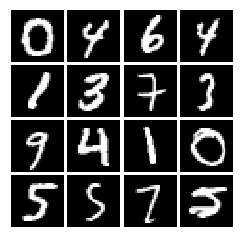

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## LeakyReLU
In the cell below, you should implement a LeakyReLU. See the [class notes](http://cs231n.github.io/neural-networks-1/) (where alpha is small number) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs keep ReLU units from dying and are often used in GAN methods (as are maxout units, however those increase model size and therefore are not used in this notebook).

HINT: You should be able to use `tf.maximum`

In [3]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    return tf.maximum(alpha * x, x)
    pass


Test your leaky ReLU implementation. You should get errors < 1e-10

In [4]:
def test_leaky_relu(x, y_true):
    tf.reset_default_graph()
    with get_session() as sess:
        y_tf = leaky_relu(tf.constant(x))
        y = sess.run(y_tf)
        print('Maximum error: %g'%rel_error(y_true, y))

test_leaky_relu(answers['lrelu_x'], answers['lrelu_y'])

Maximum error: 0


## Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [5]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    return tf.random_uniform([batch_size, dim], minval=-1, maxval=1, dtype=tf.float32) 
    pass


Make sure noise is the correct shape and type:

In [6]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    tf.reset_default_graph()
    with get_session() as sess:
        z = sample_noise(batch_size, dim)
        # Check z has the correct shape
        assert z.get_shape().as_list() == [batch_size, dim]
        # Make sure z is a Tensor and not a numpy array
        assert isinstance(z, tf.Tensor)
        # Check that we get different noise for different evaluations
        z1 = sess.run(z)
        z2 = sess.run(z)
        assert not np.array_equal(z1, z2)
        # Check that we get the correct range
        assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
        print("All tests passed!")
    
test_sample_noise()

All tests passed!


## Discriminator
Our first step is to build a discriminator. You should use the layers in `tf.layers` to build the model.
All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from size 784 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 1
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [7]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        fc1 = tf.layers.dense(inputs=x, units=256, activation=leaky_relu, use_bias=True)
        fc2 = tf.layers.dense(inputs=fc1, units=256, activation=leaky_relu, use_bias=True)
        fc3 = tf.layers.dense(inputs=fc2, units=1, use_bias=True)
        logits = fc3
        pass
        return logits

Test to make sure the number of parameters in the discriminator is correct:

In [8]:
def test_discriminator(true_count=267009):
    tf.reset_default_graph()
    with get_session() as sess:
        y = discriminator(tf.ones((2, 784)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in discriminator.')
        
test_discriminator()

Correct number of parameters in discriminator.


## Generator
Now to build a generator. You should use the layers in `tf.layers` to construct the model. All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from tf.shape(z)[1] (the number of noise dimensions) to 1024
 * ReLU
 * Fully connected layer from 1024 to 1024 
 * ReLU
 * Fully connected layer from 1024 to 784
 * TanH (To restrict the output to be [-1,1])

In [9]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        fc1 = tf.layers.dense(inputs=z, units=1024, activation=tf.nn.relu, use_bias=True)
        fc2 = tf.layers.dense(inputs=fc1, units=1024, activation=tf.nn.relu, use_bias=True)
        fc3 = tf.layers.dense(inputs=fc2, units=784, use_bias=True)
        img = tf.tanh(fc3)
        pass
        return img

Test to make sure the number of parameters in the generator is correct:

In [10]:
def test_generator(true_count=1858320):
    tf.reset_default_graph()
    with get_session() as sess:
        y = generator(tf.ones((1, 4)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in generator.')
        
test_generator()

Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: Use [tf.ones_like](https://www.tensorflow.org/api_docs/python/tf/ones_like) and [tf.zeros_like](https://www.tensorflow.org/api_docs/python/tf/zeros_like) to generate labels for your discriminator. Use [sigmoid_cross_entropy loss](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) to help compute your loss function. Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [11]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = None
    G_loss = None
    D_loss_1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_real),logits=logits_real))
    D_loss_2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(logits_fake),logits=logits_fake))
    D_loss = D_loss_1 + D_loss_2
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_fake),logits=logits_fake))
    pass
    return D_loss, G_loss

Test your GAN loss. Make sure both the generator and discriminator loss are correct. You should see errors less than 1e-5.

In [12]:
def test_gan_loss(logits_real, logits_fake, d_loss_true, g_loss_true):
    tf.reset_default_graph()
    with get_session() as sess:
        d_loss, g_loss = sess.run(gan_loss(tf.constant(logits_real), tf.constant(logits_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_gan_loss(answers['logits_real'], answers['logits_fake'],
              answers['d_loss_true'], answers['g_loss_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 7.19722e-17


# Optimizing our loss
Make an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns to be too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [13]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = None
    G_solver = None
    D_solver = tf.train.AdamOptimizer(learning_rate, beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate, beta1)
    pass
    return D_solver, G_solver

## Putting it all together
Now just a bit of Lego Construction.. Read this section over carefully to understand how we'll be composing the generator and discriminator

In [14]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN!
Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000. In our case, we'll simply train D(x) and G(z) with one batch each every iteration. However, papers often experiment with different schedules of training D(x) and G(z), sometimes doing one for more steps than the other, or even training each one until the loss gets "good enough" and then switching to training the other. 

In [15]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

#### Train your GAN! This should take about 10 minutes on a CPU, or less than a minute on GPU.

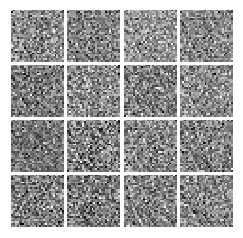


Iter: 0, D: 1.065, G:0.7396
Iter: 50, D: 0.4631, G:1.548
Iter: 100, D: 1.273, G:1.284
Iter: 150, D: 0.8453, G:1.542
Iter: 200, D: 2.524, G:0.4609


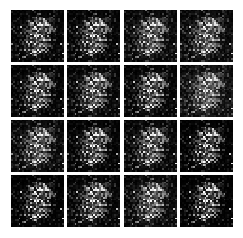


Iter: 250, D: 1.948, G:2.467
Iter: 300, D: 0.8262, G:1.838
Iter: 350, D: 1.862, G:0.9617
Iter: 400, D: 1.355, G:0.9499
Iter: 450, D: 1.127, G:1.399


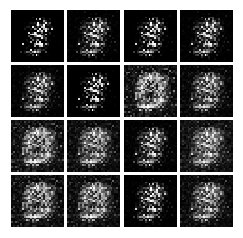


Iter: 500, D: 0.6983, G:1.961
Iter: 550, D: 1.043, G:1.277
Iter: 600, D: 0.7032, G:1.834
Iter: 650, D: 1.018, G:1.392
Iter: 700, D: 0.9486, G:1.996


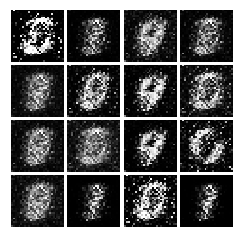


Iter: 750, D: 1.225, G:1.588
Iter: 800, D: 1.113, G:2.367
Iter: 850, D: 1.347, G:1.097
Iter: 900, D: 1.171, G:1.543
Iter: 950, D: 1.464, G:0.8236


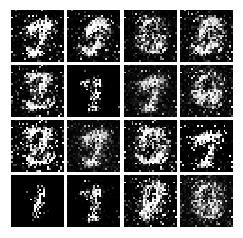


Iter: 1000, D: 1.689, G:1.092
Iter: 1050, D: 1.232, G:1.032
Iter: 1100, D: 1.212, G:1.298
Iter: 1150, D: 1.206, G:1.061
Iter: 1200, D: 1.357, G:0.9936


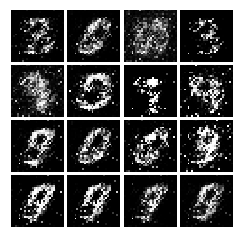


Iter: 1250, D: 1.134, G:1.369
Iter: 1300, D: 1.376, G:0.8739
Iter: 1350, D: 1.324, G:0.8469
Iter: 1400, D: 1.419, G:0.9423
Iter: 1450, D: 1.323, G:0.86


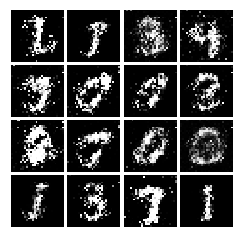


Iter: 1500, D: 1.279, G:0.9218
Iter: 1550, D: 1.171, G:0.9215
Iter: 1600, D: 1.245, G:1.077
Iter: 1650, D: 1.233, G:1.009
Iter: 1700, D: 1.209, G:1.01


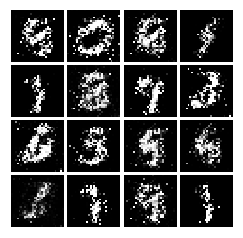


Iter: 1750, D: 1.229, G:0.913
Iter: 1800, D: 1.314, G:1.143
Iter: 1850, D: 1.234, G:0.8885
Iter: 1900, D: 1.286, G:0.9182
Iter: 1950, D: 1.367, G:0.7708


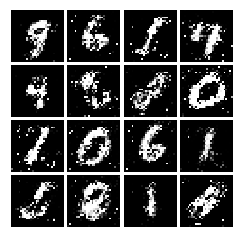


Iter: 2000, D: 1.321, G:0.8859
Iter: 2050, D: 1.229, G:0.9598
Iter: 2100, D: 1.281, G:0.9887
Iter: 2150, D: 1.244, G:0.8532
Iter: 2200, D: 1.262, G:0.9554


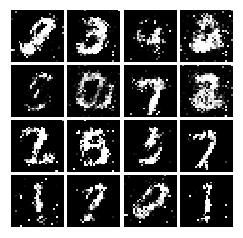


Iter: 2250, D: 1.268, G:0.8518
Iter: 2300, D: 1.252, G:0.873
Iter: 2350, D: 1.336, G:1.105
Iter: 2400, D: 1.255, G:0.8457
Iter: 2450, D: 1.294, G:0.8911


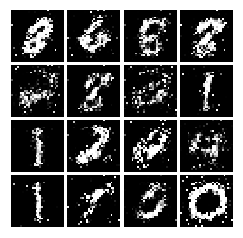


Iter: 2500, D: 1.372, G:0.7763
Iter: 2550, D: 1.354, G:0.7477
Iter: 2600, D: 1.329, G:0.7154
Iter: 2650, D: 1.305, G:0.8366
Iter: 2700, D: 1.294, G:0.7442


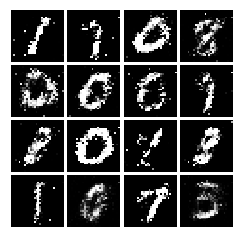


Iter: 2750, D: 1.218, G:0.7609
Iter: 2800, D: 1.363, G:0.7322
Iter: 2850, D: 1.316, G:0.8624
Iter: 2900, D: 1.304, G:0.8937
Iter: 2950, D: 1.273, G:0.7814


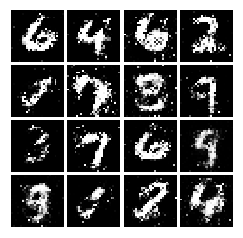


Iter: 3000, D: 1.323, G:0.8384
Iter: 3050, D: 1.294, G:0.841
Iter: 3100, D: 1.33, G:0.8161
Iter: 3150, D: 1.29, G:0.8822
Iter: 3200, D: 1.346, G:0.9104


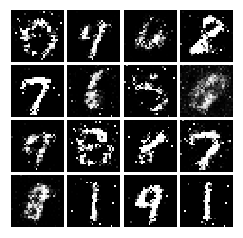


Iter: 3250, D: 1.359, G:0.7673
Iter: 3300, D: 1.3, G:0.8122
Iter: 3350, D: 1.286, G:0.7935
Iter: 3400, D: 1.262, G:0.7776
Iter: 3450, D: 1.33, G:0.8053


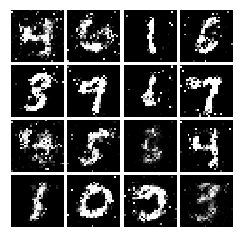


Iter: 3500, D: 1.38, G:0.8665
Iter: 3550, D: 1.316, G:0.896
Iter: 3600, D: 1.265, G:0.8751
Iter: 3650, D: 1.33, G:0.797
Iter: 3700, D: 1.337, G:0.8409


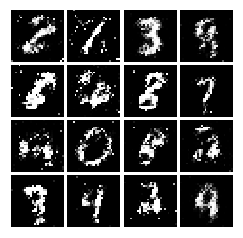


Iter: 3750, D: 1.228, G:0.934
Iter: 3800, D: 1.269, G:0.8586
Iter: 3850, D: 1.382, G:0.8213
Iter: 3900, D: 1.297, G:0.7783
Iter: 3950, D: 1.362, G:0.6859


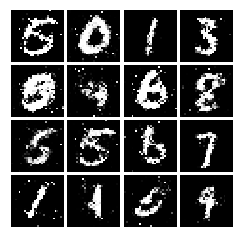


Iter: 4000, D: 1.327, G:0.8412
Iter: 4050, D: 1.346, G:0.7497
Iter: 4100, D: 1.33, G:0.8116
Iter: 4150, D: 1.303, G:0.7577
Iter: 4200, D: 1.405, G:0.8386


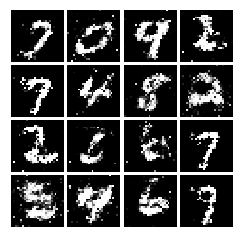


Iter: 4250, D: 1.35, G:0.7767
Final images


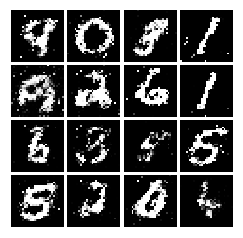

In [16]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`score_real` and `score_fake`).

In [17]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = None
    G_loss = None
    D_loss = 0.5 * tf.reduce_mean(tf.pow(score_real - 1, 2)) + 0.5 * tf.reduce_mean(tf.pow(score_fake, 2))
    G_loss = 0.5 * tf.reduce_mean(tf.pow(score_fake - 1, 2))
    pass
    return D_loss, G_loss

Test your LSGAN loss. You should see errors less than 1e-7.

In [18]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    with get_session() as sess:
        d_loss, g_loss = sess.run(
            lsgan_loss(tf.constant(score_real), tf.constant(score_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


Create new training steps so we instead minimize the LSGAN loss:

In [19]:
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

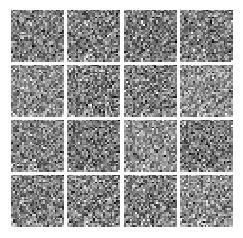


Iter: 0, D: 1.884, G:0.5175
Iter: 50, D: 0.03301, G:0.4784
Iter: 100, D: 0.01601, G:0.6758
Iter: 150, D: 0.07021, G:1.472
Iter: 200, D: 0.001665, G:0.5135


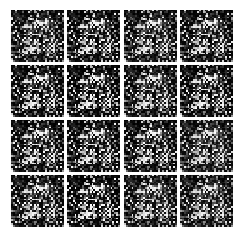


Iter: 250, D: 0.007102, G:0.5757
Iter: 300, D: 0.04978, G:0.8323
Iter: 350, D: 0.0482, G:0.3384
Iter: 400, D: 0.2317, G:0.597
Iter: 450, D: 0.1454, G:0.1489


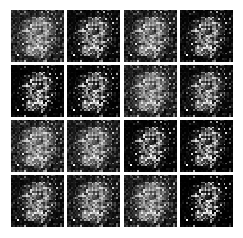


Iter: 500, D: 0.1705, G:0.2488
Iter: 550, D: 0.2781, G:0.4759
Iter: 600, D: 0.2016, G:0.2018
Iter: 650, D: 0.2122, G:0.311
Iter: 700, D: 0.1333, G:0.4737


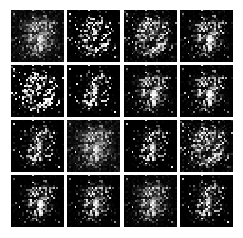


Iter: 750, D: 0.1347, G:0.3598
Iter: 800, D: 0.2192, G:0.3454
Iter: 850, D: 0.1408, G:0.2928
Iter: 900, D: 0.1309, G:0.441
Iter: 950, D: 0.1669, G:0.4072


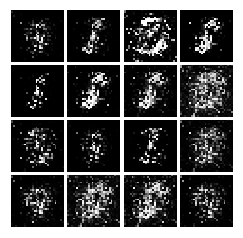


Iter: 1000, D: 0.2078, G:0.2065
Iter: 1050, D: 0.1629, G:0.2534
Iter: 1100, D: 0.1814, G:0.4227
Iter: 1150, D: 0.1741, G:0.199
Iter: 1200, D: 0.182, G:0.2239


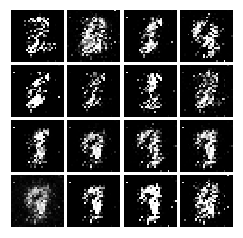


Iter: 1250, D: 0.2163, G:0.2313
Iter: 1300, D: 0.2009, G:0.2365
Iter: 1350, D: 0.2008, G:0.1973
Iter: 1400, D: 0.2196, G:0.1862
Iter: 1450, D: 0.2276, G:0.2166


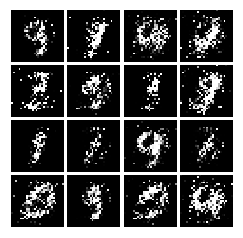


Iter: 1500, D: 0.1893, G:0.09861
Iter: 1550, D: 0.2199, G:0.199
Iter: 1600, D: 0.2076, G:0.1706
Iter: 1650, D: 0.1891, G:0.2011
Iter: 1700, D: 0.2019, G:0.1883


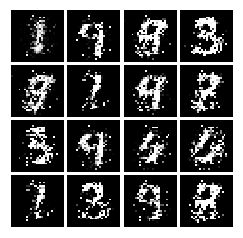


Iter: 1750, D: 0.2251, G:0.1762
Iter: 1800, D: 0.1845, G:0.1862
Iter: 1850, D: 0.6046, G:0.5652
Iter: 1900, D: 0.22, G:0.1585
Iter: 1950, D: 0.2119, G:0.185


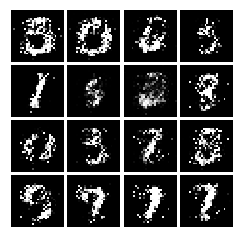


Iter: 2000, D: 0.2334, G:0.1657
Iter: 2050, D: 0.169, G:0.2116
Iter: 2100, D: 0.1876, G:0.1996
Iter: 2150, D: 0.2234, G:0.2091
Iter: 2200, D: 0.2155, G:0.205


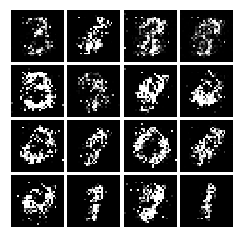


Iter: 2250, D: 0.2077, G:0.2115
Iter: 2300, D: 0.2091, G:0.229
Iter: 2350, D: 0.2026, G:0.1925
Iter: 2400, D: 0.2288, G:0.1552
Iter: 2450, D: 0.2399, G:0.1642


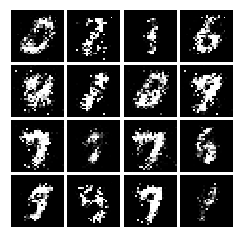


Iter: 2500, D: 0.2147, G:0.1955
Iter: 2550, D: 0.2136, G:0.1663
Iter: 2600, D: 0.232, G:0.1704
Iter: 2650, D: 0.2129, G:0.1542
Iter: 2700, D: 0.2486, G:0.2038


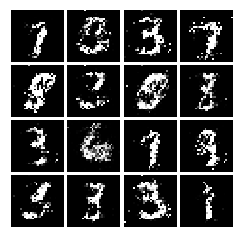


Iter: 2750, D: 0.2325, G:0.1569
Iter: 2800, D: 0.2274, G:0.1447
Iter: 2850, D: 0.2241, G:0.1429
Iter: 2900, D: 0.2304, G:0.1504
Iter: 2950, D: 0.2188, G:0.1814


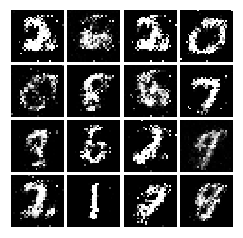


Iter: 3000, D: 0.2396, G:0.1738
Iter: 3050, D: 0.2279, G:0.1528
Iter: 3100, D: 0.2221, G:0.17
Iter: 3150, D: 0.2171, G:0.1578
Iter: 3200, D: 0.2216, G:0.1681


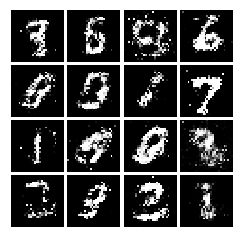


Iter: 3250, D: 0.2394, G:0.1699
Iter: 3300, D: 0.2393, G:0.1733
Iter: 3350, D: 0.2122, G:0.1891
Iter: 3400, D: 0.2235, G:0.1864
Iter: 3450, D: 0.2128, G:0.1998


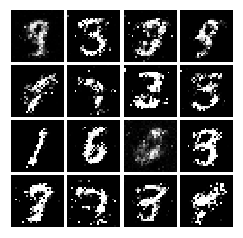


Iter: 3500, D: 0.2344, G:0.1932
Iter: 3550, D: 0.2151, G:0.1553
Iter: 3600, D: 0.2221, G:0.1528
Iter: 3650, D: 0.202, G:0.1812
Iter: 3700, D: 0.2146, G:0.1527


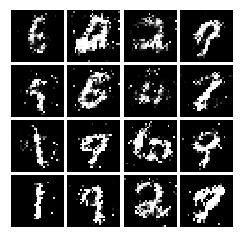


Iter: 3750, D: 0.214, G:0.1778
Iter: 3800, D: 0.231, G:0.1786
Iter: 3850, D: 0.2028, G:0.1905
Iter: 3900, D: 0.2351, G:0.2102
Iter: 3950, D: 0.2366, G:0.1702


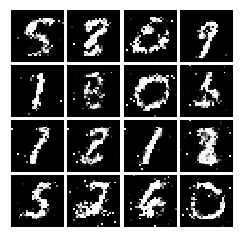


Iter: 4000, D: 0.2347, G:0.1617
Iter: 4050, D: 0.2302, G:0.1737
Iter: 4100, D: 0.216, G:0.1547
Iter: 4150, D: 0.2276, G:0.1578
Iter: 4200, D: 0.2336, G:0.16


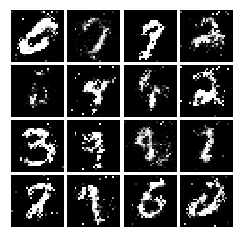


Iter: 4250, D: 0.2344, G:0.1708
Final images


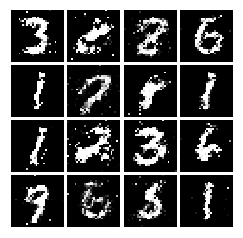

In [20]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)

# INLINE QUESTION 1:
Describe how the visual quality of the samples changes over the course of training. Do you notice anything about the distribution of the samples? How do the results change across different training runs?

** (Write Your Answer In This Cell) **

# Deep Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks as our discriminators and generators.

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification [tutorial](https://www.tensorflow.org/get_started/mnist/pros), which is able to get above 99% accuracy on the MNIST dataset fairly quickly. *Be sure to check the dimensions of x and reshape when needed*, fully connected blocks expect [N,D] Tensors while conv2d blocks expect [N,H,W,C] Tensors. 

Architecture:
* 32 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* 64 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected size 4 x 4 x 64, Leaky ReLU(alpha=0.01)
* Fully Connected size 1

In [21]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        init = tf.contrib.layers.xavier_initializer(uniform=True)
        x_image = tf.reshape(x, [-1, 28, 28, 1])
        conv1 = tf.layers.conv2d(x_image, 32, 5, activation=leaky_relu, kernel_initializer=init)
        pool1 = tf.layers.max_pooling2d(conv1, 2, 2, padding='same')
        conv2 = tf.layers.conv2d(pool1, 64, 5, activation=leaky_relu, kernel_initializer=init)
        pool2 = tf.layers.max_pooling2d(conv2, 2, 2, padding='same')
        pool2_flat = tf.reshape(pool2, [-1, 4 * 4 * 64])
        fc1 = tf.layers.dense(inputs=pool2_flat, units=4 * 4 * 64, activation=leaky_relu, kernel_initializer=init)
        fc2 = tf.layers.dense(inputs=fc1, units=1, kernel_initializer=init)
        logits = fc2
        pass
        return logits
test_discriminator(1102721)

Correct number of parameters in discriminator.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). We are always "training" in GAN mode.

Architecture:
* Fully connected of size 1024, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 128, ReLU
* BatchNorm
* Resize into Image Tensor
* 64 conv2d^T (transpose) filters of 4x4, stride 2, ReLU
* BatchNorm
* 1 conv2d^T (transpose) filter of 4x4, stride 2, TanH

In [22]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        init = tf.contrib.layers.xavier_initializer(uniform=True)
        fc1 = tf.layers.dense(z, 1024, activation=tf.nn.relu, kernel_initializer=init)
        bn1 = tf.layers.batch_normalization(fc1)
        fc2 = tf.layers.dense(bn1, 7 * 7 * 128, activation=tf.nn.relu, kernel_initializer=init)
        bn2 = tf.layers.batch_normalization(fc2)
        bn2_reshape = tf.reshape(bn2, [-1, 7, 7, 128])
        deconv1 = tf.layers.conv2d_transpose(bn2_reshape, 64, 4, strides=2, padding='same', activation=tf.nn.relu, kernel_initializer=init)
        bn3 = tf.layers.batch_normalization(deconv1)
        deconv2 = tf.layers.conv2d_transpose(bn3, 1, 4, strides=2, padding='same', kernel_initializer=init)
        img = tf.tanh(deconv2)
        img = tf.reshape(img, [-1, 784])
        pass
        return img
test_generator(6595521)

Correct number of parameters in generator.


We have to recreate our network since we've changed our functions.

In [23]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

### Train and evaluate a DCGAN
This is the one part of A3 that significantly benefits from using a GPU. It takes 3 minutes on a GPU for the requested five epochs. Or about 50 minutes on a dual core laptop on CPU (feel free to use 3 epochs if you do it on CPU).

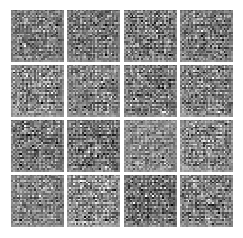


Iter: 0, D: 0.4125, G:0.3927
Iter: 50, D: 0.2932, G:0.6774
Iter: 100, D: 0.01513, G:0.4766
Iter: 150, D: 0.009906, G:0.4724
Iter: 200, D: 0.008001, G:0.495


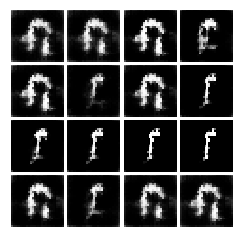


Iter: 250, D: 0.824, G:0.722
Iter: 300, D: 0.06862, G:0.4659
Iter: 350, D: 0.1393, G:0.4034
Iter: 400, D: 0.08069, G:0.389
Iter: 450, D: 0.0845, G:0.3343


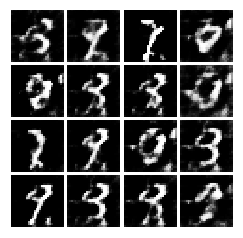


Iter: 500, D: 0.08539, G:0.3981
Iter: 550, D: 0.1097, G:0.3231
Iter: 600, D: 0.08026, G:0.4464
Iter: 650, D: 0.1061, G:0.3226
Iter: 700, D: 0.08429, G:0.3639


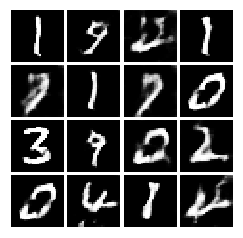


Iter: 750, D: 0.1092, G:0.4447
Iter: 800, D: 0.1175, G:0.296
Iter: 850, D: 0.1216, G:0.3448
Iter: 900, D: 0.1359, G:0.2914
Iter: 950, D: 0.1503, G:0.2899


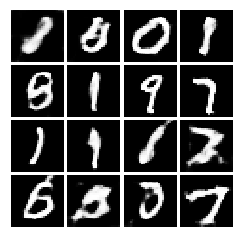


Iter: 1000, D: 0.1393, G:0.3315
Iter: 1050, D: 0.1542, G:0.3421
Iter: 1100, D: 0.1793, G:0.2517
Iter: 1150, D: 0.1493, G:0.232
Iter: 1200, D: 0.161, G:0.3273


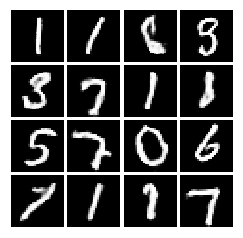


Iter: 1250, D: 0.1622, G:0.2358
Iter: 1300, D: 0.1576, G:0.2945
Iter: 1350, D: 0.1583, G:0.2595
Iter: 1400, D: 0.176, G:0.1985
Iter: 1450, D: 0.1516, G:0.2745


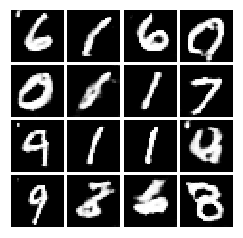


Iter: 1500, D: 0.1765, G:0.1918
Iter: 1550, D: 0.1724, G:0.2197
Iter: 1600, D: 0.1548, G:0.2191
Iter: 1650, D: 0.188, G:0.271
Iter: 1700, D: 0.178, G:0.2055


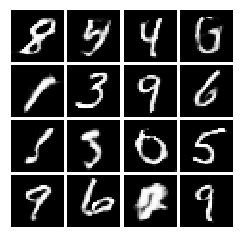


Iter: 1750, D: 0.1791, G:0.1643
Iter: 1800, D: 0.1566, G:0.262
Iter: 1850, D: 0.1621, G:0.226
Iter: 1900, D: 0.1373, G:0.2283
Iter: 1950, D: 0.1707, G:0.258


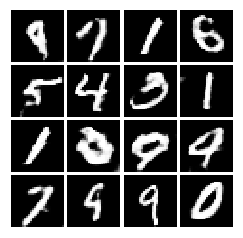


Iter: 2000, D: 0.1724, G:0.2049
Iter: 2050, D: 0.1572, G:0.2473
Iter: 2100, D: 0.1653, G:0.2296
Iter: 2150, D: 0.1646, G:0.1569
Iter: 2200, D: 0.1541, G:0.1873


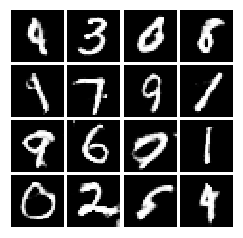


Iter: 2250, D: 0.1729, G:0.2475
Iter: 2300, D: 0.1746, G:0.2139
Iter: 2350, D: 0.1945, G:0.4724
Iter: 2400, D: 0.1713, G:0.2769
Iter: 2450, D: 0.1565, G:0.2985


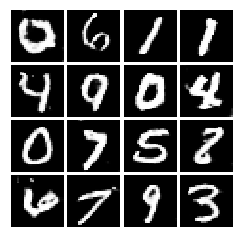


Iter: 2500, D: 0.1518, G:0.217
Iter: 2550, D: 0.1543, G:0.3266
Iter: 2600, D: 0.1416, G:0.3117
Iter: 2650, D: 0.1611, G:0.3158
Iter: 2700, D: 0.1742, G:0.4578


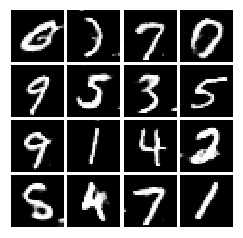


Iter: 2750, D: 0.1739, G:0.1923
Iter: 2800, D: 0.179, G:0.3724
Iter: 2850, D: 0.1625, G:0.3899
Iter: 2900, D: 0.1502, G:0.2655
Iter: 2950, D: 0.1547, G:0.3509


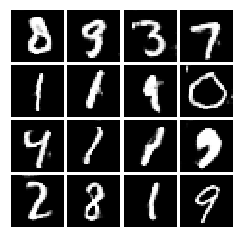


Iter: 3000, D: 0.1292, G:0.2492
Iter: 3050, D: 0.1781, G:0.2485
Iter: 3100, D: 0.1416, G:0.264
Iter: 3150, D: 0.1846, G:0.4033
Iter: 3200, D: 0.1509, G:0.17


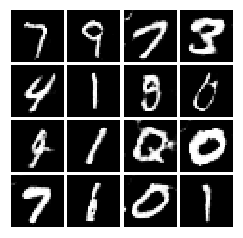


Iter: 3250, D: 0.1567, G:0.2397
Iter: 3300, D: 0.1611, G:0.402
Iter: 3350, D: 0.1491, G:0.2945
Iter: 3400, D: 0.1305, G:0.2763
Iter: 3450, D: 0.1722, G:0.1933


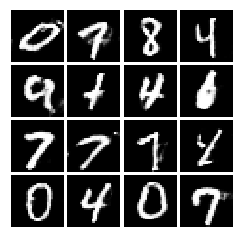


Iter: 3500, D: 0.1322, G:0.2423
Iter: 3550, D: 0.1342, G:0.2263
Iter: 3600, D: 0.1314, G:0.2037
Iter: 3650, D: 0.1362, G:0.252
Iter: 3700, D: 0.1256, G:0.3423


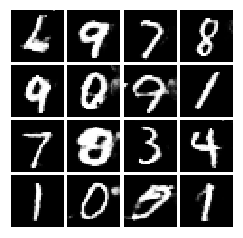


Iter: 3750, D: 0.1228, G:0.2711
Iter: 3800, D: 0.1845, G:0.1533
Iter: 3850, D: 0.151, G:0.2839
Iter: 3900, D: 0.1316, G:0.263
Iter: 3950, D: 0.1081, G:0.3509


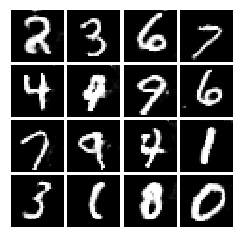


Iter: 4000, D: 0.1238, G:0.2453
Iter: 4050, D: 0.1259, G:0.2569
Iter: 4100, D: 0.1241, G:0.255
Iter: 4150, D: 0.1176, G:0.302
Iter: 4200, D: 0.1151, G:0.3047


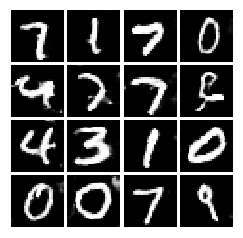


Iter: 4250, D: 0.1109, G:0.2756
Final images


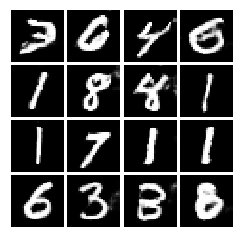

In [24]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# INLINE QUESTION 2:
What differences do you see between the DCGAN results and the original GAN results?

** (Write Your Answer In This Cell) **

------

# Extra Credit 
** Be sure you don't destroy your results above, but feel free to copy+paste code to get results below **
* For a small amount of extra credit, you can implement additional new GAN loss functions below, provided they converge. See AFI, BiGAN, Softmax GAN, Conditional GAN, InfoGAN, etc. They should converge to get credit.
* Likewise for an improved architecture or using a convolutional GAN (or even implement a VAE)
* For a bigger chunk of extra credit, load the CIFAR10 data (see last assignment) and train a compelling generative model on CIFAR-10
* Demonstrate the value of GANs in building semi-supervised models. In a semi-supervised example, only some fraction of the input data has labels; we can supervise this in MNIST by only training on a few dozen or hundred labeled examples. This was first described in [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498).
* Something new/cool.

#### Describe what you did here

# WGAN-GP (Small Extra Credit)

Please only attempt after you have completed everything above.

We'll now look at [Improved Wasserstein GAN](https://arxiv.org/abs/1704.00028) as a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement Algorithm 1 in the paper. 

You'll also need to use a discriminator and corresponding generator without max-pooling. So we cannot use the one we currently have from DCGAN. Pair the DCGAN Generator (from InfoGAN) with the discriminator from [InfoGAN](https://arxiv.org/pdf/1606.03657.pdf) Appendix C.1 MNIST (We don't use Q, simply implement the network up to D). You're also welcome to define a new generator and discriminator in this notebook, in case you want to use the fully-connected pair of D(x) and G(z) you used at the top of this notebook.

Architecture:
* 64 Filters of 4x4, stride 2, LeakyReLU
* 128 Filters of 4x4, stride 2, LeakyReLU
* BatchNorm
* Flatten
* Fully connected 1024, LeakyReLU
* Fully connected size 1

In [25]:
def discriminator(x):
    with tf.variable_scope('discriminator'):
        # TODO: implement architecture
        init = tf.contrib.layers.xavier_initializer()
        x = tf.reshape(x, [-1, 28, 28, 1])
        x = tf.layers.conv2d(x, 64, 4, activation=leaky_relu, strides=2, padding='valid',
                             kernel_initializer=init, name='conv_0')
        x = tf.layers.conv2d(x, 128, 4, activation=leaky_relu, strides=2, padding='valid',
                             kernel_initializer=init, name='conv_1')
        x = tf.layers.batch_normalization(x, name='batchnorm_0')
        x = tf.reshape(x, [-1, 3200])
        x = tf.layers.dense(x, 1024, activation=leaky_relu, kernel_initializer=init,
                            name='dense_0')
        logits = tf.layers.dense(x, 1, kernel_initializer=init, name='logits')
        pass
        return logits
test_discriminator(3411649)

Correct number of parameters in discriminator.


In [26]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator')

D_solver, G_solver = get_solvers()

In [27]:
def wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample):
    """Compute the WGAN-GP loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    - batch_size: The number of examples in this batch
    - x: the input (real) images for this batch
    - G_sample: the generated (fake) images for this batch
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    #Reference: This part is the same as it in 
    #https://github.com/madalinabuzau/CS231n-Convolutional-Neural-Networks-for-Visual-Recognition/blob/master/2017%20Spring%20Assignments/
    #assignment3/GANs-TensorFlow.ipynb
    # TODO: compute D_loss and G_loss
    D_loss = tf.reduce_mean(logits_fake-logits_real)
    G_loss = -tf.reduce_mean(logits_fake)

    # lambda from the paper
    lam = 10
    
    # random sample of batch_size (tf.random_uniform)
    eps = tf.random_uniform([batch_size,1], minval=0.0, maxval=1.0)
    x_hat = eps*x+(1-eps)*G_sample
    
    # Gradients of Gradients is kind of tricky!
    with tf.variable_scope('',reuse=True) as scope:
        grad_D_x_hat = tf.gradients(discriminator(x_hat), x_hat)

    grad_norm = tf.norm(grad_D_x_hat[0], axis=1, ord='euclidean')
    grad_pen = tf.reduce_mean(lam*tf.square(grad_norm-1))
    
    D_loss += grad_pen

    return D_loss, G_loss

D_loss, G_loss = wgangp_loss(logits_real, logits_fake, 128, x, G_sample)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

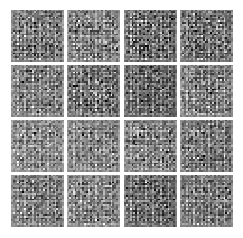


Iter: 0, D: 8.378, G:-0.04834
Iter: 50, D: -21.75, G:1.812
Iter: 100, D: -14.02, G:-10.29
Iter: 150, D: -14.96, G:-5.987
Iter: 200, D: -7.566, G:-11.04


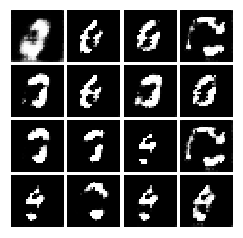


Iter: 250, D: -7.138, G:-2.602
Iter: 300, D: -6.566, G:-8.621
Iter: 350, D: -3.048, G:4.608
Iter: 400, D: -5.346, G:22.16
Iter: 450, D: -2.034, G:7.455


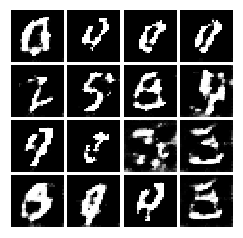


Iter: 500, D: -3.974, G:11.12
Iter: 550, D: -3.179, G:-0.2543
Iter: 600, D: -2.979, G:-5.25
Iter: 650, D: -2.484, G:-5.076
Iter: 700, D: -2.47, G:2.562


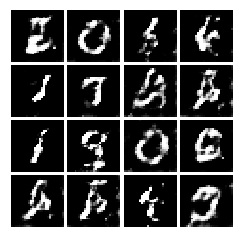


Iter: 750, D: -2.097, G:3.285
Iter: 800, D: -2.348, G:0.02546
Iter: 850, D: -2.04, G:-1.908
Iter: 900, D: -0.4312, G:0.3488
Iter: 950, D: -1.489, G:-0.1206


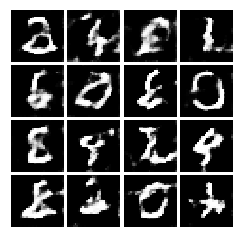


Iter: 1000, D: -1.301, G:-4.141
Iter: 1050, D: -0.6287, G:3.717
Iter: 1100, D: -0.7784, G:-0.2882
Iter: 1150, D: -1.147, G:-1.195
Iter: 1200, D: -0.8733, G:1.284


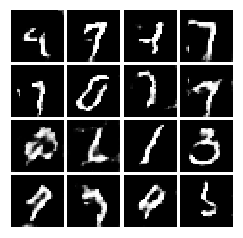


Iter: 1250, D: -0.6225, G:0.3832
Iter: 1300, D: -1.42, G:-2.204
Iter: 1350, D: -1.156, G:3.812
Iter: 1400, D: -1.555, G:3.0
Iter: 1450, D: 0.1791, G:-6.066


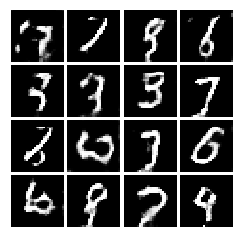


Iter: 1500, D: -0.5268, G:-1.311
Iter: 1550, D: -0.8534, G:-1.33
Iter: 1600, D: -0.5167, G:-0.1096
Iter: 1650, D: -0.4791, G:2.214
Iter: 1700, D: -0.5537, G:1.079


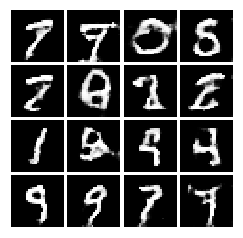


Iter: 1750, D: -0.1709, G:-8.268
Iter: 1800, D: -0.3716, G:6.038
Iter: 1850, D: -0.4384, G:-6.985
Iter: 1900, D: -1.678, G:-5.639
Iter: 1950, D: -0.3438, G:-7.214


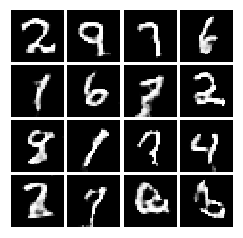


Iter: 2000, D: -0.3091, G:4.568
Iter: 2050, D: 0.5866, G:4.899
Iter: 2100, D: 0.4134, G:11.18
Iter: 2150, D: 0.1991, G:11.07
Iter: 2200, D: -0.7138, G:9.313


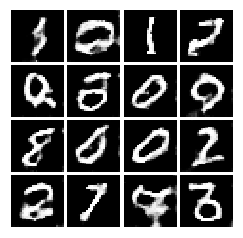


Iter: 2250, D: 0.08253, G:-2.771
Iter: 2300, D: -0.194, G:0.08227
Iter: 2350, D: -1.222, G:3.478
Iter: 2400, D: -0.4075, G:0.3863
Iter: 2450, D: -0.5626, G:-2.031


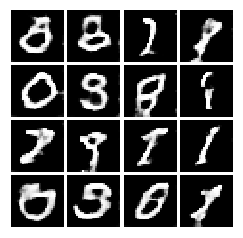


Iter: 2500, D: -0.5122, G:-8.442
Iter: 2550, D: -0.318, G:-19.39
Iter: 2600, D: 0.3176, G:10.31
Iter: 2650, D: -0.2126, G:20.96
Iter: 2700, D: -0.03626, G:3.357


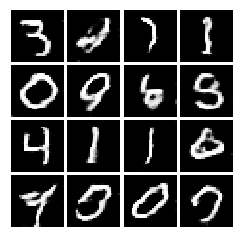


Iter: 2750, D: -0.4672, G:3.266
Iter: 2800, D: -0.5163, G:0.4157
Iter: 2850, D: 0.9863, G:-1.14
Iter: 2900, D: 0.5816, G:-8.932
Iter: 2950, D: -0.4095, G:5.816


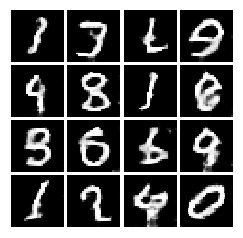


Iter: 3000, D: -0.8148, G:-28.27
Iter: 3050, D: 0.143, G:-2.909
Iter: 3100, D: -0.9755, G:7.949
Iter: 3150, D: -0.118, G:1.812
Iter: 3200, D: 0.8268, G:19.11


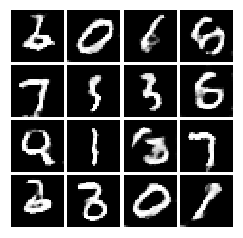


Iter: 3250, D: -0.8223, G:2.588
Iter: 3300, D: 0.2491, G:2.325
Iter: 3350, D: 1.013, G:14.71
Iter: 3400, D: -0.3892, G:7.134
Iter: 3450, D: -0.6911, G:-0.9498


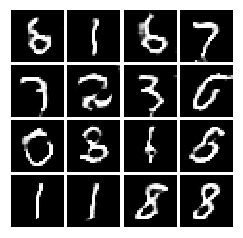


Iter: 3500, D: -0.02353, G:0.9008
Iter: 3550, D: 0.4559, G:-4.259
Iter: 3600, D: -0.3408, G:7.004
Iter: 3650, D: -0.2037, G:-10.47
Iter: 3700, D: 0.5142, G:7.777


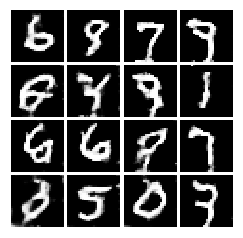


Iter: 3750, D: 0.5752, G:-6.246
Iter: 3800, D: -0.5324, G:1.652
Iter: 3850, D: 0.1582, G:6.382
Iter: 3900, D: -1.425, G:8.102
Iter: 3950, D: -0.3208, G:2.852


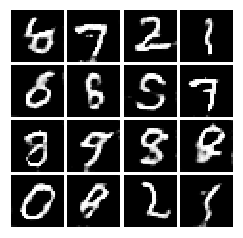


Iter: 4000, D: -0.08219, G:2.256
Iter: 4050, D: -0.04164, G:-15.44
Iter: 4100, D: 0.4047, G:-11.54
Iter: 4150, D: -0.8839, G:-20.56
Iter: 4200, D: 0.3323, G:-7.484


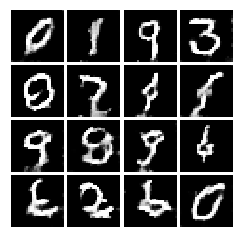


Iter: 4250, D: -0.2482, G:-3.856
Final images


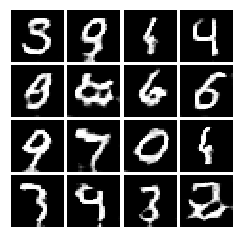

In [28]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,batch_size=128)